In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array

In [2]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    "./data/train",
    target_size=(128,128),
    batch_size=16,
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "./data/test",
    target_size=(128,128),
    batch_size=16,
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode='categorical')

Found 735 images belonging to 7 classes.
Found 315 images belonging to 7 classes.


In [3]:

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss') < 0.1):
            self.model.stop_training = True
    
        
        
            
callbacks = myCallback()

In [4]:
n_classes = 7

model = Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(7, activation='softmax')
])
    
model.compile(optimizer = 'adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 31, 31, 128)       0

In [5]:
# epochs = 20

# history = model.fit(x = train_generator,
#                     validation_data=test_generator ,
#                     batch_size=16,
#                     verbose=1, 
#                     epochs=epochs,
#                     callbacks=[callbacks]
#                    )

In [6]:
# model.evaluate(test_generator)

In [7]:
# no_epochs = len(history.history['loss'])

# loss_train = history.history['loss']
# loss_val = history.history['val_loss']
# ep = range(no_epochs)
# plt.plot(ep, loss_train, label='Training loss')
# plt.plot(ep, loss_val, label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [8]:
# loss_train = history.history['accuracy']
# loss_val = history.history['val_accuracy']
# ep = range(no_epochs)
# plt.plot(ep, loss_train,label='Training accuracy')
# plt.plot(ep, loss_val, label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [9]:
cnn_features_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('flatten').output)

train_generator.reset()
num_train_samples = len(train_generator.filenames)
train_cnn_features = cnn_features_model.predict(train_generator, steps=num_train_samples/train_generator.batch_size, verbose=1)

test_generator.reset()
num_test_samples = len(test_generator.filenames)
test_cnn_features = cnn_features_model.predict(test_generator, steps=num_test_samples/test_generator.batch_size, verbose=1)

19/19 [==============================] - 2s 105ms/step


In [10]:
#KNN
train_generator.reset()
test_generator.reset()

from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_cnn_features, train_generator.classes)
knn_pred = knn_model.predict(test_cnn_features)

from sklearn.metrics import accuracy_score,mean_squared_error
print(accuracy_score(test_generator.classes,knn_pred))


0.15873015873015872


In [11]:
#Ada Boost
train_generator.reset()
test_generator.reset()


from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
AB_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3),
    n_estimators=10
)
AB_model.fit(train_cnn_features, train_generator.classes)
ada_pred = AB_model.predict(test_cnn_features)

print(accuracy_score(test_generator.classes,ada_pred))


0.1111111111111111


In [12]:
#XG boost
train_generator.reset()
test_generator.reset()

from xgboost import XGBClassifier
XG_model = XGBClassifier()
XG_model.fit(train_cnn_features, train_generator.classes)
XG_pred = XG_model.predict(test_cnn_features)

print(accuracy_score(test_generator.classes,XG_pred))


0.1523809523809524


In [13]:
def single_predict(file):
    test_image=load_img(file, target_size=(128,128))
    test_image=img_to_array(test_image)
    test_image=np.expand_dims(test_image,axis=0)
    result=model.predict(test_image)
    sorted_classes = ['10', '100', '20', '200', '2000', '50', '500']
    return sorted_classes[result.argmax()]

In [14]:
single_predict("data/single/500rs.jpg")

1/1 [==============================] - 0s 76ms/step


'2000'

In [15]:
train_generator.class_indices

{'10': 0, '100': 1, '20': 2, '200': 3, '2000': 4, '50': 5, '500': 6}

In [16]:
# model.save_weights('optimised_CNN')

In [17]:
# import cv2
# import numpy as np


# url = input()
# cap = cv2.VideoCapture(url+"/video")

# while(True):
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     fontScale = 1
#     color = (255, 0, 0)
#     thickness = 2
    
#     ret, frame = cap.read()
#     cv2.imwrite("cv_clicked.jpg",frame)
#     res = single_predict("cv_clicked.jpg")
#     print(res)
#     cv2.putText(frame,res,(50, 50),font,fontScale,color,thickness)
#     cv2.imshow('frame',frame)
    
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

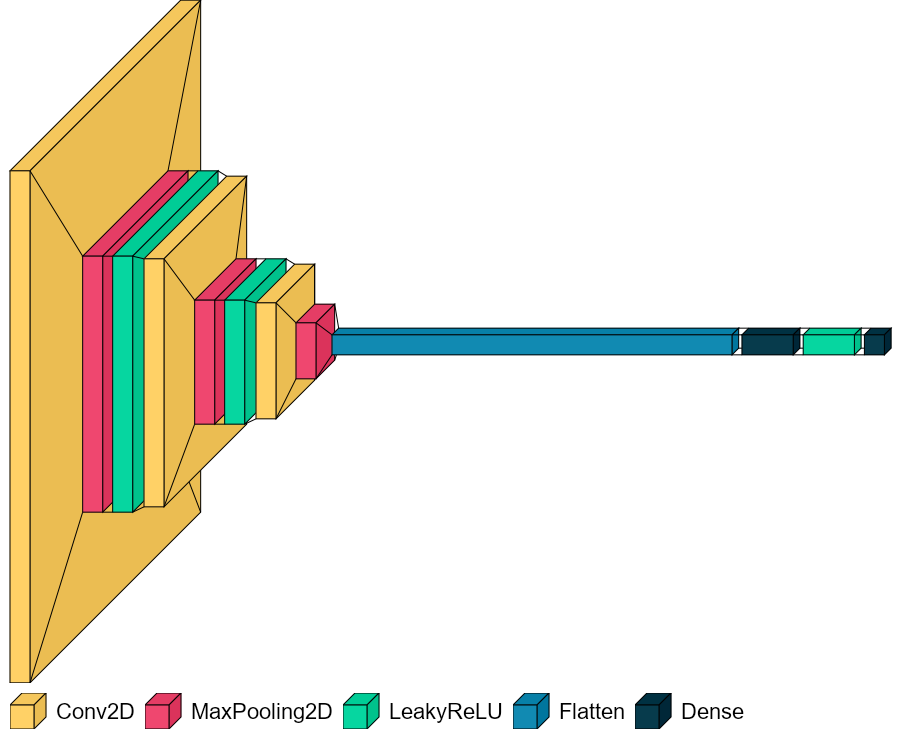

In [30]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 22)
visualkeras.layered_view(model,legend=True,font=font)